<a href="https://colab.research.google.com/github/anniebritton/ISAMR-Research/blob/main/Wapusk_GreenUp_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Ideas

Sea ice (can play a big role in NDVI), albedo???

wget local weather station  - Wapusk

https://prairieclimatecentre.ca/about-us/ - modeling out predictions going forward

use variables to predict when the caribou would show up - ML

# **Colab Set Up**

In [ ]:
# installs and import libraries
!pip install earthengine-api
!pip install geemap
!pip install geopandas 
!pip install matplotlib
!pip install pyshp
!pip install pycrs


import ee
import geemap.foliumap as geemap
import shapefile
import pycrs
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.rcParams["figure.figsize"] = (20,3)

In [ ]:
# initialise ee, copy and paste the authentication code
try:
        ee.Initialize()
except Exception as e:
        ee.Authenticate()
        ee.Initialize()

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

#**Import AOI**

In [ ]:
# import and create a variable for the shapefile
AOI_path = "/content/drive/MyDrive/Personal/ISAMR/Shapefiles/Wapusk_Shapefile/wapusk_np_gcs.shp"

# convert the shapefile into an Earth Engine object
AOI = geemap.shp_to_ee(AOI_path)


In [ ]:
# Create a Map instance
map = geemap.Map()

# Add the AOI to the map
map.addLayer(AOI, {'color': 'red'}, name='AOI')

# Center the map on the AOI
map.centerObject(AOI)

# Display the map
map

#**MODIS Masking & NDVI Calculation**

In [ ]:
# First, a function to mask out cloudy pixels
def mask_clouds(image):
    # Select the QA band
    QA = image.select('state_1km')
    # Make a mask to get bit 10, the internal cloud algorithm flag bit
    bit_mask = 1 << 10
    # Return an image masking out cloudy areas
    return image.updateMask(QA.bitwiseAnd(bit_mask).eq(0))


# Next, a function to mask out pixels with snow
def mask_snow(image):
    # Select the QA band
    QA = image.select('state_1km')
    # Make a mask to get bit 15, the internal snow mask bit
    bit_mask = 1 << 15
    # Return an image masking out snowy areas
    return image.updateMask(QA.bitwiseAnd(bit_mask).eq(0))


# Get MODIS surface reflectance image collection
mod09ga = ee.ImageCollection("MODIS/006/MOD09GA")

# Filter image collections by date and apply the mask_clouds and mask_snow functions
mod09ga_masked = mod09ga.filterDate('2000-02-27', '2021-12-31').map(mask_clouds).map(mask_snow)

In [ ]:
# Next, a function to calculate and create a new NDVI band
def get_NDVI(imagecol):
    ndvi = imagecol.normalizedDifference(['sur_refl_b02', 'sur_refl_b01']).rename("NDVI")
    return imagecol.addBands(ndvi).select('NDVI').copyProperties(imagecol)

# Add NDVI as a band to the image
mod09ga_NDVI = mod09ga_masked.map(get_NDVI)

# **Data Acquisition**

In [ ]:
# MODIS NDVI
NDVI_list = [mod09ga_NDVI, 'NDVI', AOI, 1000 ]

# MODIS Terra Snow Cover Daily Global 500m
NDSI_list = [ee.ImageCollection("MODIS/006/MOD10A1").filterDate('2000-02-27','2021-12-31'), 'NDSI_Snow_Cover', AOI, 500]

# MOD11A1.061 Terra Land Surface Temperature and Emissivity Daily Global 1km
DayLST_list = [ee.ImageCollection("MODIS/061/MOD11A1").filterDate('2000-02-27','2021-12-31'), 'LST_Day_1km', AOI, 1000]
NightLST_list = [ee.ImageCollection("MODIS/061/MOD11A1").filterDate('2000-02-27','2021-12-31'), 'LST_Night_1km', AOI, 1000]

# Daymet
Precip_list = [ee.ImageCollection("NASA/ORNL/DAYMET_V4").filterDate('2000-02-27','2021-12-31'), 'prcp', AOI, 1000]
Srad_list = [ee.ImageCollection("NASA/ORNL/DAYMET_V4").filterDate('2000-02-27','2021-12-31'), 'srad', AOI, 1000]
SWE_list = [ee.ImageCollection("NASA/ORNL/DAYMET_V4").filterDate('2000-02-27','2021-12-31'), 'swe', AOI, 1000]
Tmax_list = [ee.ImageCollection("NASA/ORNL/DAYMET_V4").filterDate('2000-02-27','2021-12-31'), 'tmax', AOI, 1000]
Tmin_list = [ee.ImageCollection("NASA/ORNL/DAYMET_V4").filterDate('2000-02-27','2021-12-31'), 'tmin', AOI, 1000]
VaporPres_list = [ee.ImageCollection("NASA/ORNL/DAYMET_V4").filterDate('2000-02-27','2021-12-31'), 'vp', AOI, 1000]
	
# ERA5
Vwind_list = [ee.ImageCollection("ECMWF/ERA5_LAND/DAILY_AGGR").filterDate('2000-02-27','2021-12-31'), 'v_component_of_wind_10m', AOI, 11132]
Uwind_list = [ee.ImageCollection("ECMWF/ERA5_LAND/DAILY_AGGR").filterDate('2000-02-27','2021-12-31'), 'u_component_of_wind_10m', AOI, 11132]
Snowmelt_list= [ee.ImageCollection("ECMWF/ERA5_LAND/DAILY_AGGR").filterDate('2000-02-27','2021-12-31'), 'snowmelt_sum', AOI, 11132]
Snowfall_list = [ee.ImageCollection("ECMWF/ERA5_LAND/DAILY_AGGR").filterDate('2000-02-27','2021-12-31'), 'snowfall_sum', AOI, 11132]
Snowcover_list = [ee.ImageCollection("ECMWF/ERA5_LAND/DAILY_AGGR").filterDate('2000-02-27','2021-12-31'), 'snow_cover', AOI, 11132]
Snowdensity_list = [ee.ImageCollection("ECMWF/ERA5_LAND/DAILY_AGGR").filterDate('2000-02-27','2021-12-31'), 'snow_density', AOI, 11132]
Snowdepth_list = [ee.ImageCollection("ECMWF/ERA5_LAND/DAILY_AGGR").filterDate('2000-02-27','2021-12-31'), 'snow_depth', AOI, 11132]
LAIhigh_list = [ee.ImageCollection("ECMWF/ERA5_LAND/DAILY_AGGR").filterDate('2000-02-27','2021-12-31'), 'leaf_area_index_high_vegetation', AOI, 11132]
LAIlow_list = [ee.ImageCollection("ECMWF/ERA5_LAND/DAILY_AGGR").filterDate('2000-02-27','2021-12-31'), 'leaf_area_index_low_vegetation', AOI, 11132]

In [ ]:
def spatialtimeseries(datalist):
  
    data = datalist[0]
    band = datalist[1]
    geometry = datalist[2]
    scale = datalist[3]

    # reduce the image collection to the area of study and to the correct bands
    def aoi_mean(img):
        mean = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=geometry, scale=scale).get(band)
        return img.set('date', img.date().format()).set('mean', mean)

    # Map this function to every image in our collection to get a new 
    # ImageCollection, but now each image has the mean value for the region of interest and the date. 
    aoi_reduced_imgs = data.map(aoi_mean)

    # Reduce the images to a list of lists:
    # for each image, we have a 2-element list that contains that images date and mean value (for our point of interest)
    # each of these lists are themselves elements in our outer list, which is what we’ll convert to a dataframe
    nested_list = aoi_reduced_imgs.reduceColumns(ee.Reducer.toList(2), ['date','mean']).values().get(0)

    # This nested list can be turned into a dataframe using the .DataFrame constructor.
    # Call the callback method "getInfo" to retrieve the data
    df = pd.DataFrame(nested_list.getInfo(), columns=['date','mean'])

    # Set the date column to be the index.
    df['date'] = pd.to_datetime(df['date']).dt.date
    df = df.set_index('date')

    return(df)

In [ ]:
# MODIS NDVI
NDVI_df = spatialtimeseries(NDVI_list)

In [ ]:
# MODIS Terra Snow Cover Daily Global 500m
NDSI_df = spatialtimeseries(NDSI_list)

In [ ]:
# MOD11A1.061 Terra Land Surface Temperature and Emissivity Daily Global 1km
DayLST_df = spatialtimeseries(DayLST_list) 
NightLST_df = spatialtimeseries(NightLST_list)

# Adjust for MODIS temperature scale and convert to C
DayLST_df = DayLST_df * 0.02 - 273.15
NightLST_df= NightLST_df * 0.02 - 273.15

In [ ]:
# Daymet 1
Precip_df = spatialtimeseries(Precip_list)
Srad_df = spatialtimeseries(Srad_list)
SWE_df = spatialtimeseries(SWE_list)

In [ ]:
# Daymet 2
Tmax_df = spatialtimeseries(Tmax_list)
Tmin_df = spatialtimeseries(Tmin_list)
VaporPres_df = spatialtimeseries(VaporPres_list)

In [ ]:
# ERA5 2
Vwind_df = spatialtimeseries(Vwind_list)
Uwind_df = spatialtimeseries(Uwind_list)
Snowmelt_df = spatialtimeseries(Snowmelt_list)
Snowfall_df = spatialtimeseries(Snowfall_list)

In [ ]:
# ERA5 1
Snowcover_df = spatialtimeseries(Snowcover_list)
Snowdensity_df = spatialtimeseries(Snowdensity_list)
Snowdepth_df = spatialtimeseries(Snowdepth_list)
LAIhigh_df = spatialtimeseries(LAIhigh_list)
LAIlow_df = spatialtimeseries(LAIlow_list)

In [ ]:
# Create a list of the dataframe names
df_list = [NDVI_df, NDSI_df, DayLST_df, NightLST_df, Precip_df, Srad_df, SWE_df, Tmax_df, Tmin_df, VaporPres_df,
           Vwind_df, Uwind_df, Snowmelt_df, Snowfall_df, Snowcover_df, Snowdensity_df, Snowdepth_df, LAIhigh_df, LAIlow_df]

# Create a list of the variables names
var_names = ['NDVI', 'NDSI', "DayLST", "NightLST", "Precip", "SolarRad", "SWE", "Tmax", "Tmin", "VaporPressure",
             "VWind", "UWind", "Snowmelt", "Snowfall", "SnowCover", "SnowDensity", "SnowDepth", "LeafAreaHigh", "LeafAreaLow"]

# Create an empty dataframe to fill
df_whole = pd.DataFrame()

# Set the index to match the index of the data 
# using tmin because it runs for the full daily series of data
df_whole.index = Tmax_df.index

# For loop that adds each column to the new df and renames it
for i, df in enumerate(df_list):
  df_whole[var_names[i]] = df['mean']

# reset the index to avoid annoying datetime issues
df_whole = df_whole.reset_index()
df_whole['date'] = pd.to_datetime(df_whole['date'], utc=True).dt.strftime('%Y-%m-%d')
df_whole = df_whole.set_index('date')
# df_whole.index = pd.to_datetime(df_whole.index)

# interpolate missing values
df_whole = df_whole.interpolate(method='linear')

# Define wind columns
u = df_whole['UWind']
v = df_whole['VWind']

# Calculate wind speed
speed = np.sqrt(u**2 + v**2)
df_whole['WindSpeed'] = speed

# Calculate wind direction
direction = np.arctan2(u, v) * 180/np.pi + 180
df_whole['WindDirection'] = direction

df_whole

,NDVI,NDSI,DayLST,NightLST,Precip,SolarRad,SWE,Tmax,Tmin,VaporPressure,...,UWind,Snowmelt,Snowfall,SnowCover,SnowDensity,SnowDepth,LeafAreaHigh,LeafAreaLow,WindSpeed,WindDirection
date,,,,,,,,,,,,,,,,,,,,,
2000-02-27,NaN,76.516149,-11.970387,-18.151989,0.000000,153.667617,64.911445,-10.784094,-17.797520,150.873357,...,4.771497,0.0,0.000219,96.402762,209.582728,0.547076,0.170864,0.779725,7.520751,320.621224
2000-02-28,-0.586143,82.846451,-6.160794,-17.650815,0.000000,210.378199,64.911445,-4.231809,-15.375307,183.953540,...,0.925211,0.0,0.000056,96.402762,212.060367,0.540157,0.170864,0.779725,2.590127,200.928761
2000-02-29,-0.334017,71.230067,-10.969949,-18.053482,0.065479,141.917274,64.976944,-7.790133,-13.929580,209.196236,...,-4.839920,0.0,0.000063,96.402762,214.656263,0.533531,0.170864,0.779725,5.286629,66.277151
2000-03-01,-0.081890,73.296511,-11.131869,-12.265676,0.000008,235.579445,64.976950,-3.164199,-16.269884,168.657866,...,2.633229,0.0,0.000125,96.402762,217.166189,0.527083,0.170864,0.779725,4.890105,327.419694
2000-03-02,-0.202716,69.512972,-2.359538,-14.285173,0.000000,179.845880,64.976950,-0.943830,-8.956282,308.644252,...,3.509574,0.0,0.000324,96.402762,219.634731,0.521287,0.170864,0.779725,4.228607,236.094609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-26,-0.434459,64.503176,-30.551036,-27.056629,0.000000,44.804853,29.105918,-20.152488,-31.748698,42.644328,...,7.368758,0.0,0.000094,96.402762,149.987568,0.395248,0.170910,0.779730,7.388372,274.175790
2021-12-27,-0.434459,60.832824,-31.194905,-33.474352,0.000000,41.419877,29.105918,-23.135591,-32.775185,38.570735,...,2.407860,0.0,0.000007,96.402762,151.267679,0.391989,0.170908,0.779730,2.609048,292.647945
2021-12-28,-0.434459,62.791685,-31.911936,-32.454444,0.000000,32.320825,29.105918,-21.226347,-27.668271,62.752782,...,-2.974748,0.0,0.000012,96.402762,151.779000,0.390812,0.170905,0.779730,2.974783,89.719711


# **Initial Data Viz**

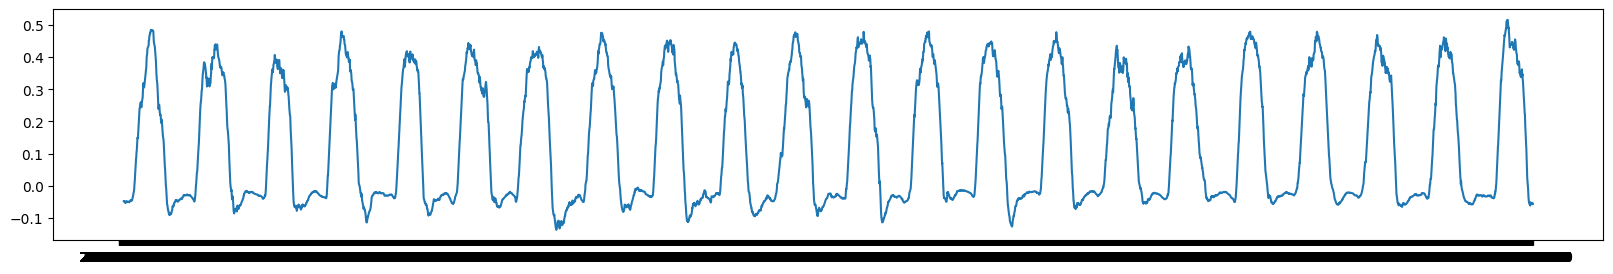

In [ ]:
rolling = df_whole[["NDVI"]].rolling(window=30).mean()
plt.plot(rolling)

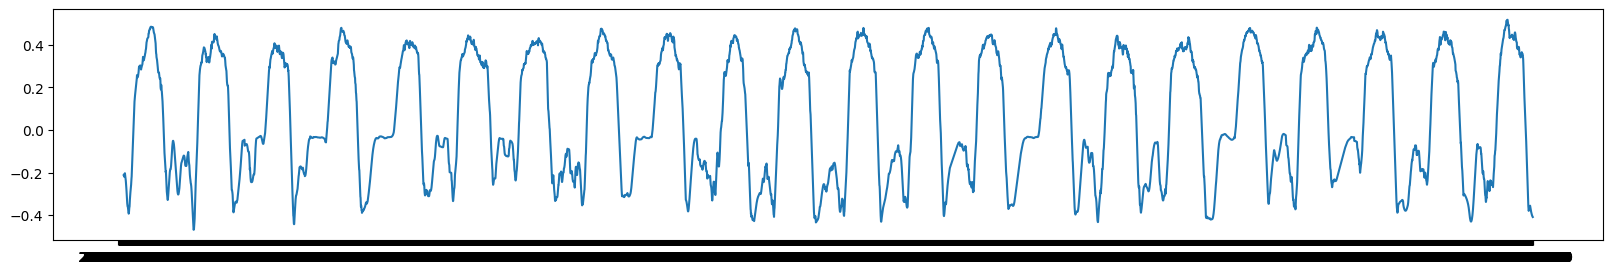

In [ ]:
rolling = df_whole[["NDVI"]].rolling(window=30).mean()
plt.plot(rolling)

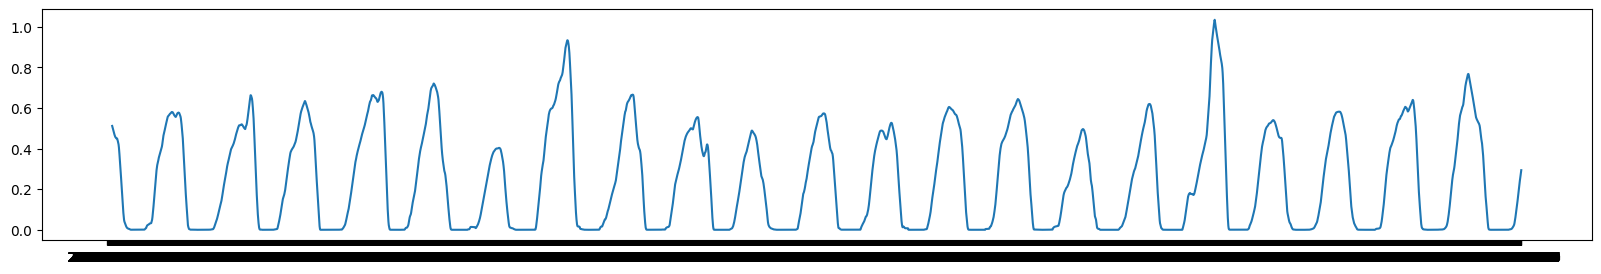

In [ ]:
rolling = df_whole[["SnowDepth"]].rolling(window=30).mean()
plt.plot(rolling)

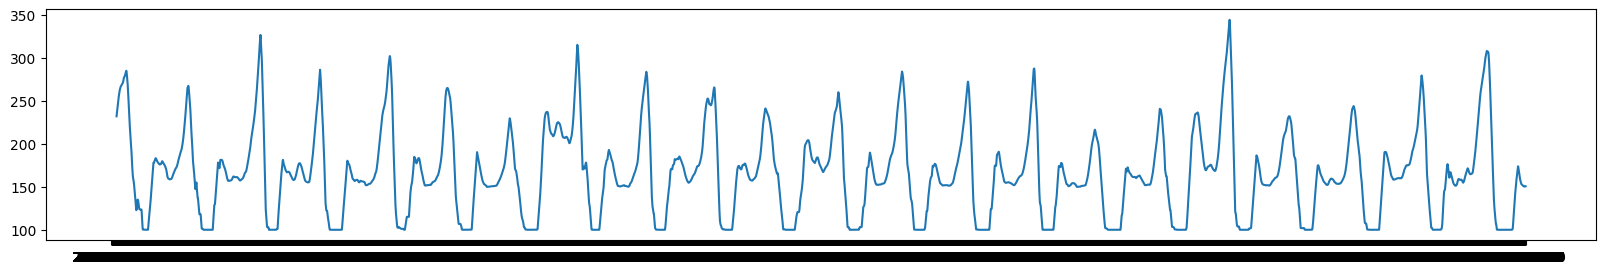

In [ ]:
rolling = df_whole[["SnowDensity"]].rolling(window=30).mean()
plt.plot(rolling)

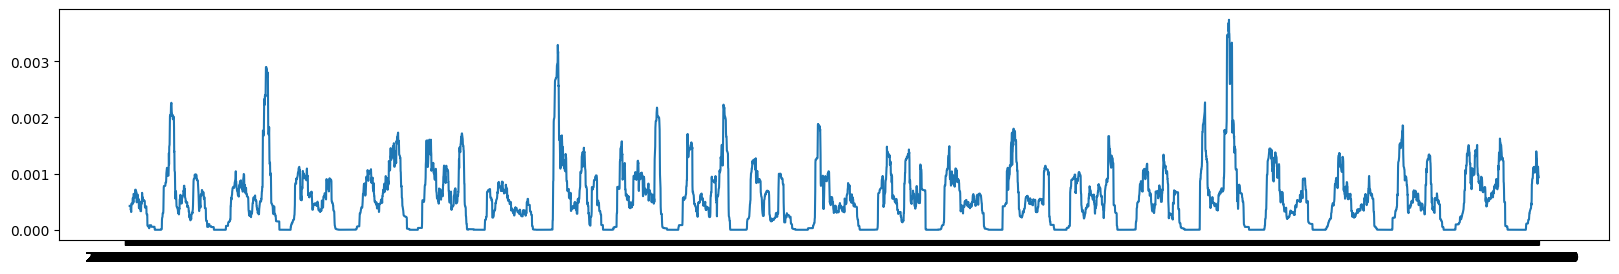

In [ ]:
rolling = df_whole[["Snowfall"]].rolling(window=30).mean()
plt.plot(rolling)

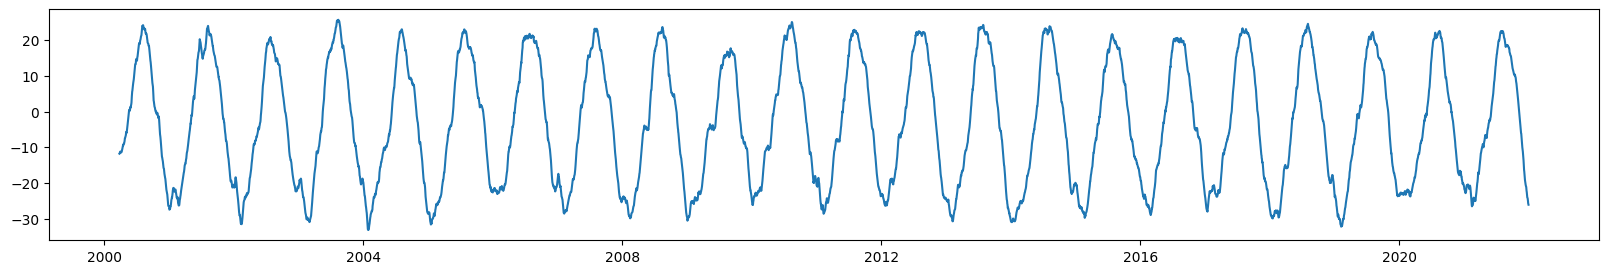

In [ ]:
rolling = df_whole[["DayLST"]].rolling(window=30).mean()
plt.plot(rolling)

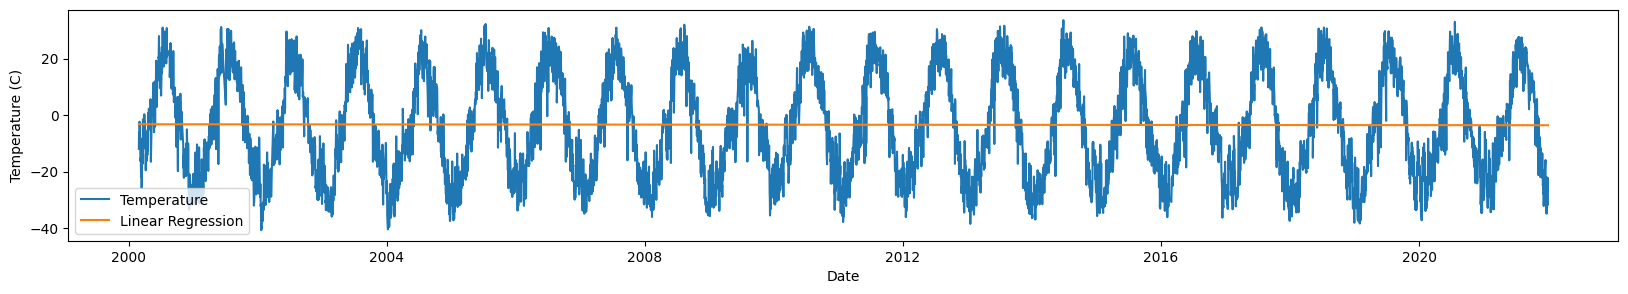

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Fit linear regression using scikit-learn
reg = LinearRegression().fit(np.arange(len(df_whole)).reshape(-1, 1), df_whole["DayLST"])

# Plot temperature and linear regression
plt.plot(df_whole.index, df_whole["DayLST"], label="Temperature")
plt.plot(df_whole.index, reg.predict(np.arange(len(df_whole)).reshape(-1, 1)), label="Linear Regression")
plt.xlabel("Date")
plt.ylabel("Temperature (C)")
plt.legend()
plt.show()


#**Wind Viz**

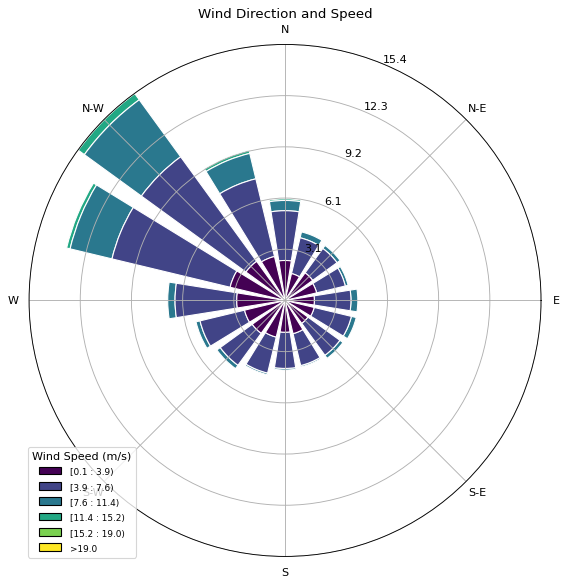

In [ ]:
from windrose import WindroseAxes

# Create windrose plot
ax = WindroseAxes.from_ax()
ax.bar(df_whole["WindDirection"], df_whole["WindSpeed"], normed=True, opening=0.8, edgecolor='white')

# Customize plot
ax.set_legend(title='Wind Speed (m/s)')
plt.title('Wind Direction and Speed')
plt.show()

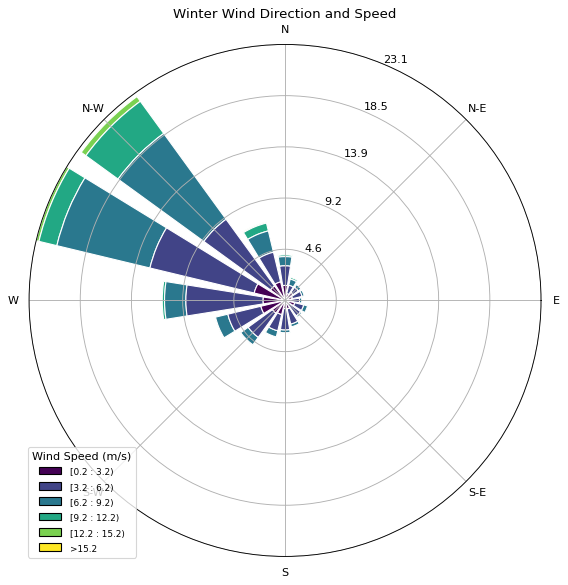

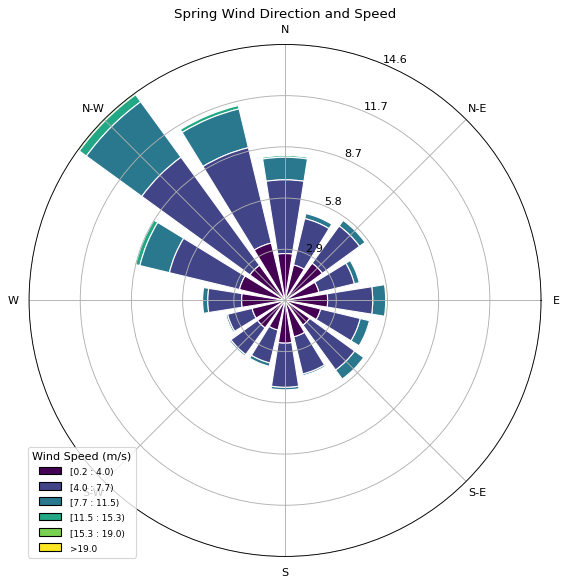

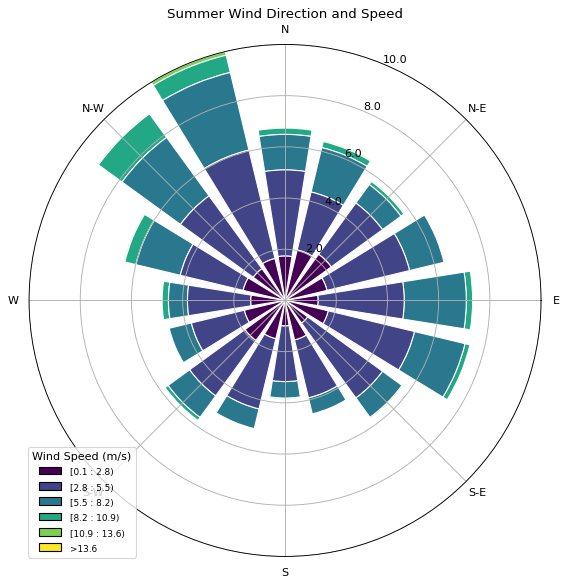

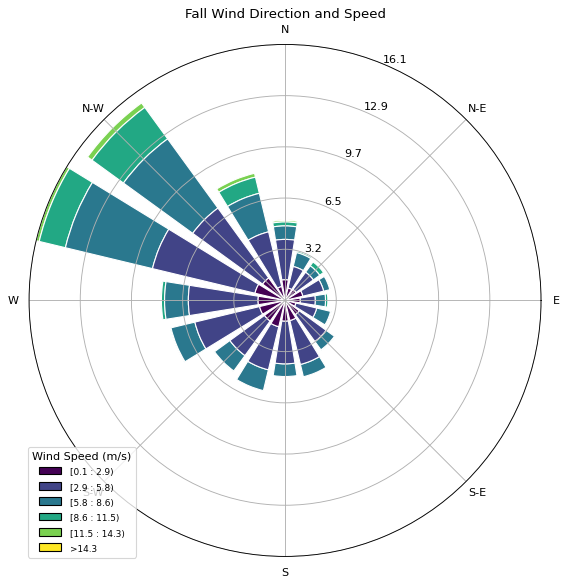

In [ ]:
# Define function to get season from month
def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Fall"

# Add season column to dataframe
df_whole["Season"] = df_whole.index.month.map(get_season)

# Loop through each season and create a wind rose plot
for season in df_whole["Season"].unique():
    # Subset dataframe for the current season
    df_season = df_whole[df_whole["Season"] == season]
    
    # Create windrose plot
    ax = WindroseAxes.from_ax()
    ax.bar(df_season["WindDirection"], df_season["WindSpeed"], normed=True, opening=0.8, edgecolor='white')
    
    # Customize plot
    ax.set_legend(title='Wind Speed (m/s)')
    plt.title(f'{season} Wind Direction and Speed')
    plt.show()

# **Finding the Green-Up Date**


From Mallory et al., 2020: To estimate the beginning of green-up annually on the Qamanirjuaq calving area from 2004 to 2016, we used a documented relationship between remotely sensed normalized difference vegetation index (NDVI) and maximum nitrogen concentration of tundra vegetation, whereby the date at which NDVI reaches half its annual maximum reasonably predicts peak nitrogen concentration, and by association, green-up (Doiron et al. 2013, 2015). 

Slope: 0.3760587238848109


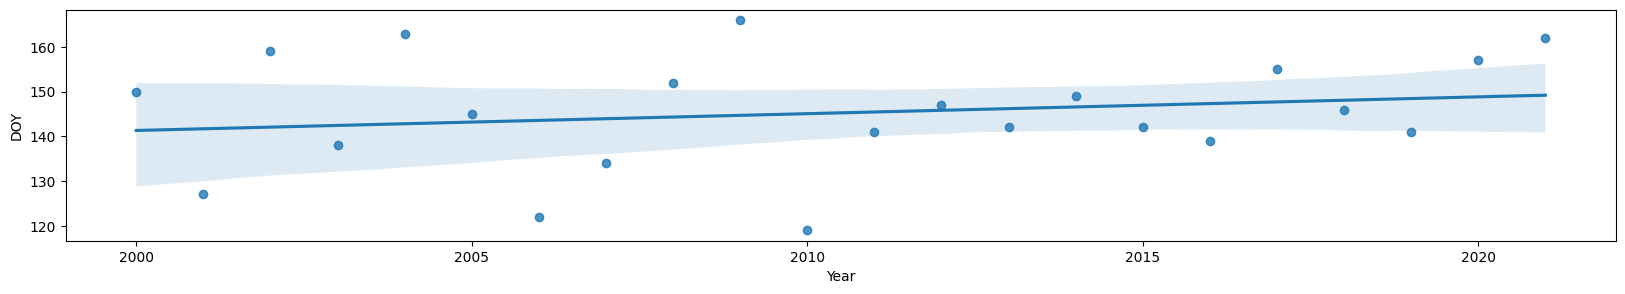

In [ ]:
import seaborn as sns
from sklearn.linear_model import LinearRegression

df_whole.index = pd.to_datetime(df_whole.index)
ndvi = df_whole['NDVI']

# Group by year and find the maximum NDVI value for each year
grouped = ndvi.groupby(ndvi.index.year)
annual_max = grouped.max()

# Compute half of each year's maximum NDVI value
half_max = annual_max / 2.0

# Find the index of the first NDVI value that exceeds half of the annual maximum for each year
doy_half_max = {}
for year, max_val in half_max.items():
    year_ndvi = ndvi[str(year)]
    first_exceed = year_ndvi[year_ndvi >= max_val].index[0]
    doy_half_max[year] = first_exceed.dayofyear

# Create a DataFrame from the year/day-of-year pairs
df_half_max = pd.DataFrame.from_dict(doy_half_max, orient='index', columns=['DOY'])

# Add a column for the year
df_half_max['Year'] = df_half_max.index

# Plot the data
sns.regplot(x='Year', y='DOY', data=df_half_max)

# Perform a linear regression
X = df_half_max['Year'].values.reshape(-1, 1)
y = df_half_max['DOY'].values.reshape(-1, 1)
model = LinearRegression()
model.fit(X, y)

# Print the slope of the regression line
print(f"Slope: {model.coef_[0][0]}")

# Show the plot
plt.show()


Slope: 0.11123658949745904


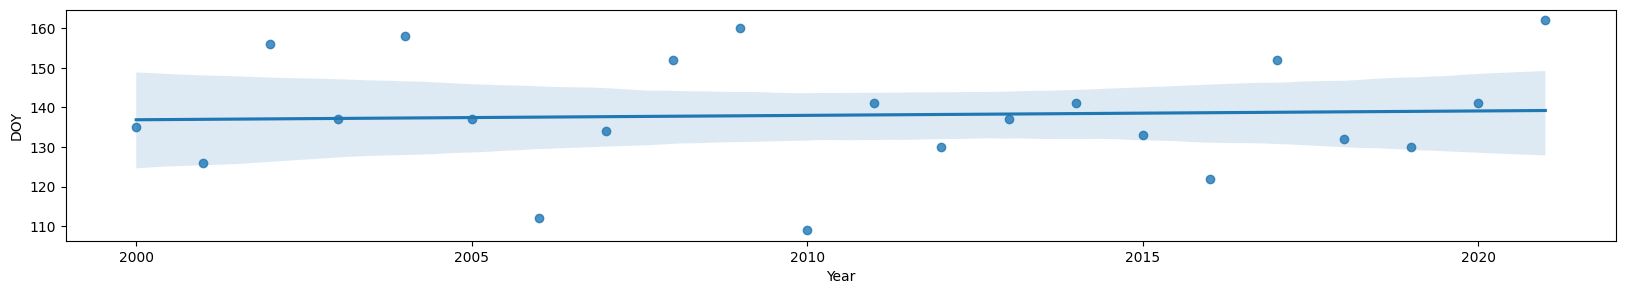

In [ ]:
import seaborn as sns
from sklearn.linear_model import LinearRegression

df_whole.index = pd.to_datetime(df_whole.index)
ndvi = df_whole['NDVI']

# Group by year and find the maximum NDVI value for each year
grouped = ndvi.groupby(ndvi.index.year)
annual_max = grouped.max()

# Compute half of each year's maximum NDVI value
half_max = annual_max / 2.0

# Find the index of the first NDVI value that exceeds half of the annual maximum for each year
doy_half_max = {}
for year, max_val in half_max.items():
    year_ndvi = ndvi[str(year)]
    first_exceed = year_ndvi[year_ndvi >= max_val].index[0]
    doy_half_max[year] = first_exceed.dayofyear

# Create a DataFrame from the year/day-of-year pairs
df_half_max = pd.DataFrame.from_dict(doy_half_max, orient='index', columns=['DOY'])

# Add a column for the year
df_half_max['Year'] = df_half_max.index

# Plot the data
sns.regplot(x='Year', y='DOY', data=df_half_max)

# Perform a linear regression
X = df_half_max['Year'].values.reshape(-1, 1)
y = df_half_max['DOY'].values.reshape(-1, 1)
model = LinearRegression()
model.fit(X, y)

# Print the slope of the regression line
print(f"Slope: {model.coef_[0][0]}")

# Show the plot
plt.show()

Slope: 0.12987012987012975


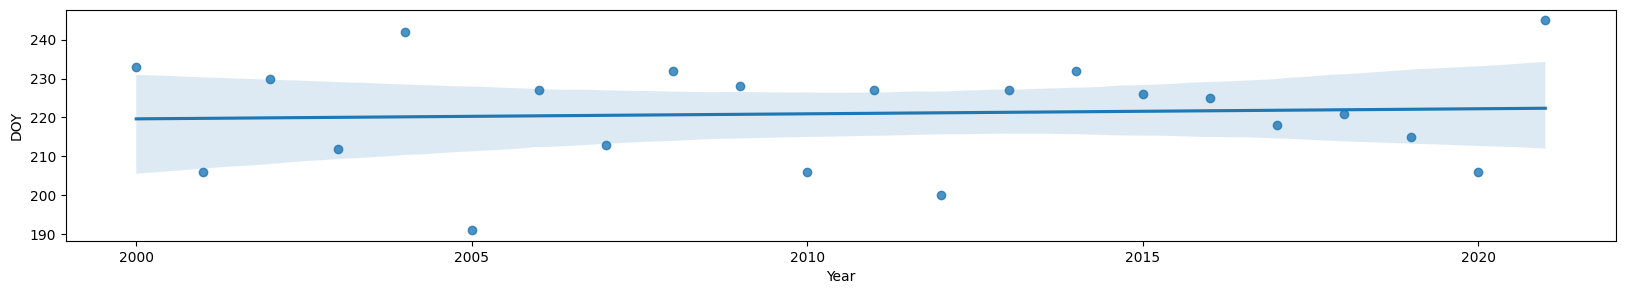

In [ ]:
df_whole.index = pd.to_datetime(df_whole.index)
ndvi = df_whole['NDVI']

# Group by year and find the maximum NDVI value and the day of year of that maximum value
grouped = ndvi.groupby(ndvi.index.year)
annual_max = grouped.max()
annual_doy_max = grouped.apply(lambda x: x.idxmax().dayofyear)

# Create a DataFrame from the year/day-of-year pairs
df_max = pd.DataFrame({'DOY': annual_doy_max, 'Year': annual_max.index})

# Plot the data
sns.regplot(x='Year', y='DOY', data=df_max)

# Perform a linear regression
X = df_max['Year'].values.reshape(-1, 1)
y = df_max['DOY'].values.reshape(-1, 1)
model = LinearRegression()
model.fit(X, y)

# Print the slope of the regression line
print(f"Slope: {model.coef_[0][0]}")

# Show the plot
plt.show()

Slope: -0.6216826651609261


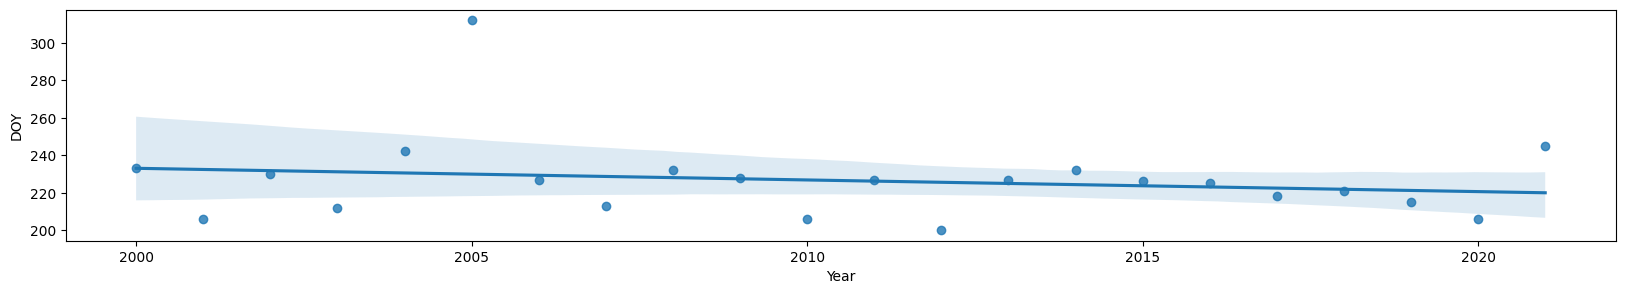

In [ ]:
df_whole.index = pd.to_datetime(df_whole.index)
ndvi = df_whole['NDVI']

# Group by year and find the maximum NDVI value and the day of year of that maximum value
grouped = ndvi.groupby(ndvi.index.year)
annual_max = grouped.max()
annual_doy_max = grouped.apply(lambda x: x.idxmax().dayofyear)

# Create a DataFrame from the year/day-of-year pairs
df_max = pd.DataFrame({'DOY': annual_doy_max, 'Year': annual_max.index})

# Plot the data
sns.regplot(x='Year', y='DOY', data=df_max)

# Perform a linear regression
X = df_max['Year'].values.reshape(-1, 1)
y = df_max['DOY'].values.reshape(-1, 1)
model = LinearRegression()
model.fit(X, y)

# Print the slope of the regression line
print(f"Slope: {model.coef_[0][0]}")

# Show the plot
plt.show()

#**Calculate Anomalies**

In [ ]:
# Function that will calculate the daily mean for each variable and then 
# subsequently calculate the anomaly for each variable/day
def calculate_anomaly(df, value_col):
    
    # Group the data by day of the year and calculate the average for each day of the year
    df_daily_grouping = df.groupby(df.index.dayofyear).mean()

    # Create a dictionary mapping day of year to average value
    day_of_year_to_mean = df_daily_grouping[value_col].to_dict()

    # Map the day of year to the average value for that day of year
    df['day_of_year'] = df.index.dayofyear
    df[f'day_of_year_{value_col}_mean'] = df['day_of_year'].map(day_of_year_to_mean)

    # Calculate the daily anomaly as the difference between the original value and the average value for that day of year
    df[f'{value_col}_anomaly'] = df[value_col] - df[f'day_of_year_{value_col}_mean']

# Apply the function to each column of the dataframe
for col in df_whole.columns:
    if col != 'date':
        calculate_anomaly(df_whole, col)

In [ ]:
# Reduce the dataframe so that it only contains the anomaly data
df_anom = df_whole[df_whole.columns[df_whole.columns.str.endswith('_anomaly')]]
df_anom

,NDVI_anomaly,NDSI_anomaly,DayLST_anomaly,NightLST_anomaly,Precip_anomaly,SolarRad_anomaly,SWE_anomaly,Tmax_anomaly,Tmin_anomaly,VaporPressure_anomaly,...,UWind_anomaly,Snowmelt_anomaly,Snowfall_anomaly,SnowCover_anomaly,SnowDensity_anomaly,SnowDepth_anomaly,LeafAreaHigh_anomaly,LeafAreaLow_anomaly,WindSpeed_anomaly,WindDirection_anomaly
date,,,,,,,,,,,,,,,,,,,,,
2000-02-27,NaN,8.343166,11.855291,11.512860,-0.036437,-44.030201,15.642730,5.987652,9.792841,74.440227,...,2.061577,0.0,0.000034,-1.421085e-14,38.104900,-0.035859,0.000000e+00,-1.110223e-16,2.566021,75.679575
2000-02-28,-0.472745,15.638565,16.429941,11.782196,-0.430714,13.557531,15.212016,11.563326,11.134843,97.786031,...,-0.474001,0.0,-0.000148,-1.421085e-14,39.504015,-0.039844,0.000000e+00,-1.110223e-16,-2.235680,-1.317456
2000-02-29,-0.253828,2.986422,9.767120,8.778056,-0.121299,-39.780927,15.090739,7.125944,10.153190,99.987863,...,-6.602137,0.0,-0.000455,-1.421085e-14,41.327446,-0.046034,0.000000e+00,-1.110223e-16,-1.141273,-156.925351
2000-03-01,-0.003519,4.550818,9.317167,11.751526,-0.313854,39.145749,14.776880,10.794893,7.956348,70.602687,...,1.098358,0.0,-0.000189,-1.421085e-14,43.027245,-0.052512,0.000000e+00,-1.110223e-16,-0.651418,99.115014
2000-03-02,-0.116758,0.240910,17.972879,11.116861,-0.390519,-21.798898,14.386364,12.531480,15.146404,207.026183,...,1.974789,0.0,-0.000504,-1.421085e-14,44.728140,-0.058702,0.000000e+00,-1.110223e-16,-0.510478,15.845032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-26,-0.186813,6.187040,-6.318507,-1.187550,-0.367362,8.114718,1.506877,-2.584388,-6.162371,-53.238060,...,4.527350,0.0,-0.000745,-1.421085e-14,-11.582750,0.003499,-6.014021e-07,-7.517527e-08,2.702811,17.605789
2021-12-27,-0.197335,0.848409,-6.300296,-8.159471,-0.322570,3.289223,1.184306,-5.329291,-6.436256,-49.030761,...,-0.639550,0.0,-0.000630,-1.421085e-14,-10.624685,-0.002946,-6.734451e-07,-3.132303e-09,-2.137153,26.395514
2021-12-28,-0.194331,3.189746,-7.904772,-5.681463,-0.145324,-6.480985,1.038986,-3.484416,-1.458478,-20.130806,...,-5.665054,0.0,-0.000388,-1.421085e-14,-9.814277,-0.008525,-6.045344e-07,-7.204296e-08,-2.271154,-139.215801


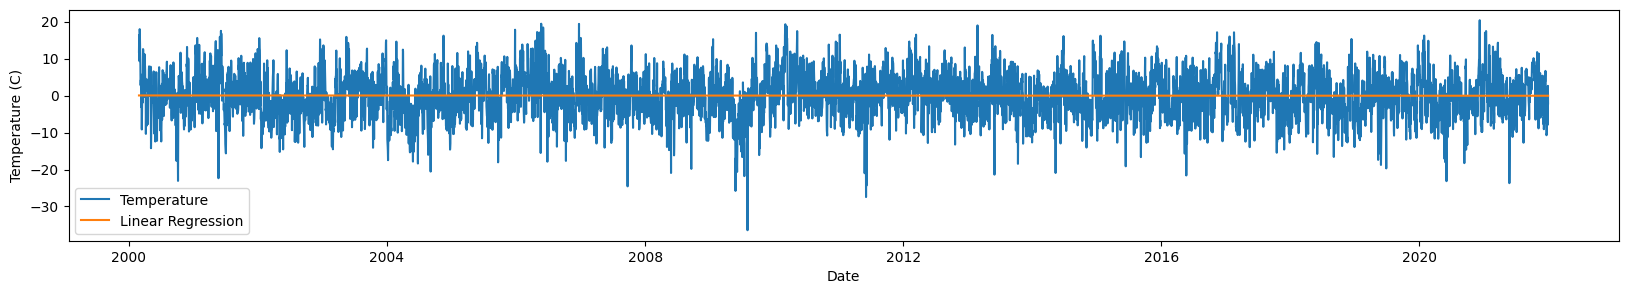

In [ ]:
# Fit linear regression using scikit-learn
reg = LinearRegression().fit(np.arange(len(df_anom)).reshape(-1, 1), df_anom["DayLST_anomaly"])

# Plot temperature and linear regression
plt.plot(df_anom.index, df_anom["DayLST_anomaly"], label="Temperature")
plt.plot(df_anom.index, reg.predict(np.arange(len(df_anom)).reshape(-1, 1)), label="Linear Regression")
plt.xlabel("Date")
plt.ylabel("Temperature (C)")
plt.legend()
plt.show()